## Projet Python pour la data science (2023-2024)
*Thomas Chen, Félix de Champs, David Premachandra*  


## Introduction : 
<div align="justify">
Comme le montre ce graphique du site Statista les surfaces de forêts qui partent chaque année en fumée n'ont cessé d'augmenter au cours de la dernière décenies.  
  
![graph_statista](/home/onyxia/ensae-prog2A/graph_statista.PNG)
  
Les incendies de forêts sont donc une préoccupation croissante des populations et des pouvoirs publiques. En effet, ces millieu d'hectares brûlés représentent non seulement une catastrophe écologique, quand on connaît l'importance des forêts pour la biodiversité ou pour la captation du $ CO_{2}$, mais aussi dans certains cas une catastrophe humaine et matériel puisque 80 % des incendies de forêts se déclenchent à moins de 50 m des habitations selon le Ministère de l'Ecologie.  
On comprend alors l'importance de comprendre les circonstances de ces incendies pour mieux les prévenir, comme par exemple essayer de déterminer précisément quelles conditions climatiques vont sont les plus propices à l'apparition d'un feu de forêts.  
Notre projet à donc pour objectif de donner la probabilité qu'un feu de forêt se déclenche dans le Sud-Est de la France, en fonction des conditions météo comme nous allons le voir par la suite.


# I] Présentation des bases de données principales


Dans cette première partie nous allons voir en détails ce que contiennent les bases de données que nous avons trouver lors de nos recherches.

### 0/ Récupération des données 

- On commence par importer les modules pour le traitement des données : pandas pour manipuler les dataframes, numpy pour faire des opérations mathématiques et datetime pour la manipulation des dates.

In [1]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt

- Ensuite on va charger les différentes bases de données sur python en les faisant passer du format csv au format dataframe de pandas:  
  
  - la base de données sur les incendies de forêt est disponible via ce [lien](https://bdiff.agriculture.gouv.fr/incendies).  
  - la base de données météo est disponible via ce [lien](https://meteonet.umr-cnrm.fr/dataset/data/SE/ground_stations/).
  - la base de données sur les communes est disponible via ce [lien](https://www.data.gouv.fr/fr/datasets/r/dbe8a621-a9c4-4bc3-9cae-be1699c5ff25).


In [2]:
import requests
import os

def download_data(url, folder_path):
    # Vérifie si le dossier 'data' existe, sinon le crée
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Récupère le nom du fichier à partir de l'URL
    file_name = url.split('/')[-1]

    # Télécharge le fichier depuis l'URL
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Le fichier a été téléchargé avec succès : {file_path}")
    else:
        print("La requête de téléchargement a échoué.")

# URL pour les données
url = "https://meteonet.umr-cnrm.fr/dataset/data/SE/ground_stations/SE_ground_stations_2018.tar.gz"

# Chemin du dossier 'data'
folder_path = '/home/onyxia/ensae-prog2A/data'

# Appel de la fonction pour télécharger les données
download_data(url, folder_path)


Le fichier a été téléchargé avec succès : /home/onyxia/ensae-prog2A/data/SE_ground_stations_2018.tar.gz


In [3]:
import tarfile
import os

def extract_tar_gz(file_path, extract_path):
    # Vérifie si le dossier d'extraction existe, sinon le crée
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    try:
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)
        print(f"Extraction réussie dans le dossier : {extract_path}")
    except Exception as e:
        print(f"Erreur lors de l'extraction : {e}")

# Chemin vers le fichier .tar.gz
file_path = '/home/onyxia/ensae-prog2A/data/SE_ground_stations_2018.tar.gz'  # Remplacez 'votre_fichier.tar.gz' par le nom de votre fichier

# Dossier pour extraire les fichiers
extract_path = '/home/onyxia/ensae-prog2A/data'

# Appel de la fonction pour extraire les fichiers
extract_tar_gz(file_path, extract_path)


Extraction réussie dans le dossier : /home/onyxia/ensae-prog2A/data


In [4]:
# Dataframe de la base de données sur les incendies: 
df_incendies = pd.read_csv(r"/home/onyxia/ensae-prog2A/data/Incendies_18.csv", sep = ';')

# Dataframe avec la base de données meteonet pour le quart sud-est :
df_meteo_SE = pd.read_csv(r'/home/onyxia/ensae-prog2A/data/SE2018.csv')

# Dataframe avec juste les stations et leurs coordonnées GPS :
df_stations_SE = df_meteo_SE[['number_sta','lat','lon']]
df_stations_SE = df_stations_SE.drop_duplicates(subset='number_sta').reset_index()

# Dataframe avec la base de données permettant de faire la correspondance commune-coordonnées GPS :
df_communes = pd.read_csv(r"/home/onyxia/ensae-prog2A/data/communes.csv")
df_communes = df_communes[['code_commune_INSEE','latitude','longitude','nom_region']]
df_communes.columns = ['code_commune_INSEE', 'lat', 'lon', 'region']
# On se restrenint aux régions qui nous intéressent
liste_regions = ['Corse', "Provence-Alpes-Côte d'Azur", "Occitanie", "Auvergne-Rhône-Alpes", 'Nouvelle-Aquitaine']
df_communes = df_communes[df_communes['region'].isin(liste_regions)].drop_duplicates(subset = 'code_commune_INSEE').reset_index()
# Correction des codes communes INSEE des départements en 0X 
for i in df_communes.index :
    if len(df_communes['code_commune_INSEE'][i])==4 :
        df_communes.loc[i, 'code_commune_INSEE'] = '0' + df_communes.loc[i, 'code_commune_INSEE']



### 1/ Base de données BDIFF

Cette base de donnée se définie comme "une application internet chargée de centraliser l'ensemble des données sur les incendies de forêt sur le territoire français depuis 2006 et de mettre l'ensemble de cette information à disposition du public et des services de l'Etat."  
  
Elle est éditée par l'IGN (Institut National de l'Information Géographique et Forestières).

Les données sur les incendies en 2018 sont contenues dans le dataframe df_incendies qui possède 1928 lignes et 37 colonnes. Chaque ligne correspond à un incendie.

In [5]:
print(df_incendies.shape)
print(df_incendies.columns)

(1634, 37)
Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Nom de la commune',
       'Date de première alerte', 'Origine de l'alerte',
       'Moyens de première intervention', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       'Surface de feu à l'arrivée des secours > 0,1 ha',
       'Voie carrossable la plus proche',
       'Activité ou habitation la plus proche', 'Type de peuplement',
       'Connaissance', 'Source de l'enquête', 'Nature',
       'Intervention de l'équipe RCCI', 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits'

On dispose de données relatives:
- au temps avec la date d'alerte 
- aux surfaces parcourues par le feu
- à l'origine de l'incendie 
- aux dégats et décès provoquées par l'incendie

Une première façon d'approcher ces données sur les incendies est de les représenter sur une carte.  
C'est ce que permet de faire le notebook `visualisation_incendies.ipynb` appelé par la cellule suivante : 

Le fichier a été téléchargé avec succès : /home/onyxia/ensae-prog2A/data/geojson?lang=fr&timezone=Europe%2FBerlin
Le fichier a été téléchargé avec succès : /home/onyxia/ensae-prog2A/data/ms:PARC_PUBL_FR?format=GeoJSON&projection=WGS84


/opt/mamba/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


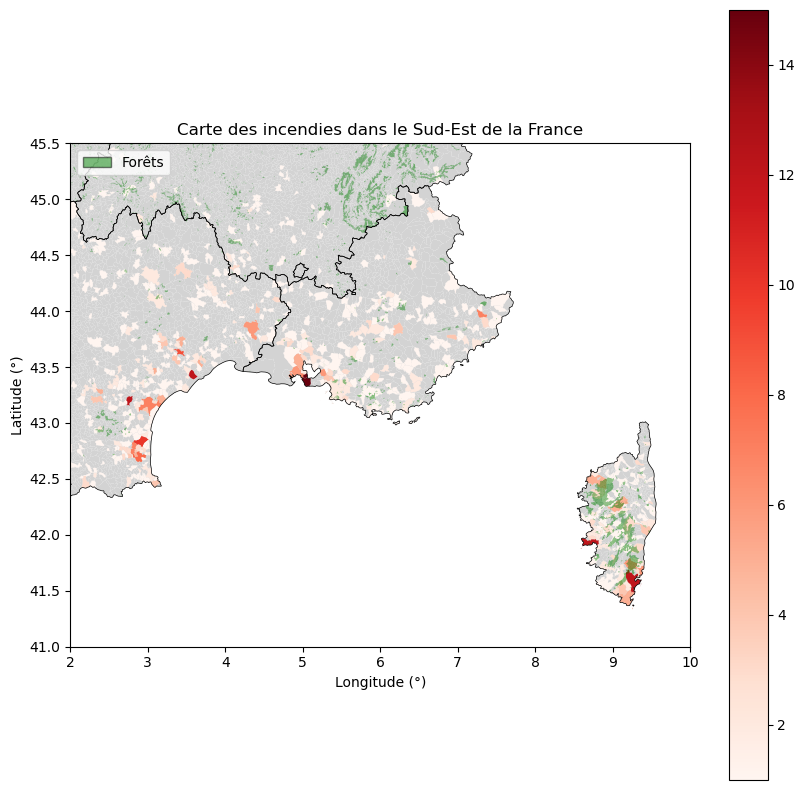

In [7]:
%run /home/onyxia/ensae-prog2A/visualisation_incendies.ipynb

<div align="justify">
Cette carte décrit le nombre d'incendies par commune dans le Sud-Est au cours de l'année 2018. On voit que plus on va vers le sud plus la densité d'incendie semble importante, avec des communes qui on jusqu'à quasiment une quinzaine d'incendie dans l'année environ, ce qui nous laisse penser qu'effectivement les condittions climatiques ont un effet sur la fréquence d'occurence des incendies. On voit également que les communes avec le plus de départ de feux ne sont pas forcément celles les plus proches des massifs forestiers représentés en vert.

Regardons à présent quelques statistiques descriptives sur les variables qualitatives relatives aux incendies:

On crée des colonnes mois et heure pour s'intéresser à l'occurence des incendies par rapport au temps.

In [8]:
df_incendies['date'] = pd.to_datetime(df_incendies['Date de première alerte'])
from datetime import datetime

df_hist_incendies = df_incendies.copy()

df_hist_incendies['date']=pd.to_datetime(df_hist_incendies['date'])
df_hist_incendies['mois']=df_hist_incendies['date'].dt.month
mois_noms = { 1: 'janvier', 2: 'février', 3: 'mars', 4: 'avril', 5: 'mai', 6: 'juin', 
             7: 'juillet', 8: 'août', 9: 'septembre', 10: 'octobre', 11: 'novembre', 12: 'décembre'}

df_hist_incendies['mois'] = df_hist_incendies['mois'].replace(mois_noms) #remplacer les valeurs numériques des mois par leurs noms

df_hist_incendies['heure']=pd.to_datetime(df_hist_incendies['Date de première alerte']).dt.hour


#### Histogrammes du nombre d'incendies par mois et par heure

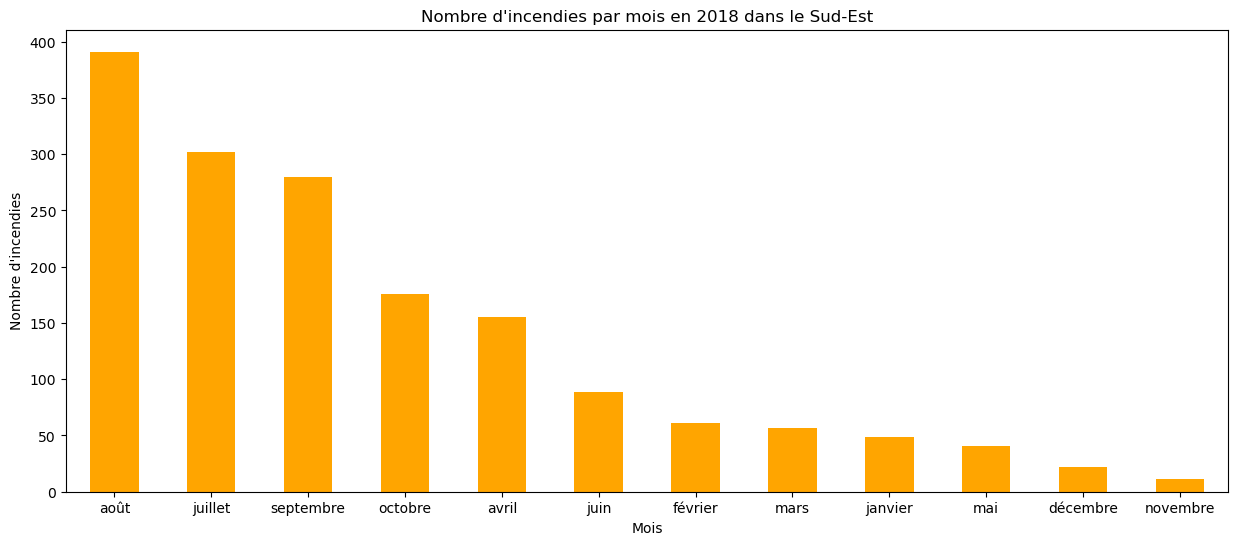

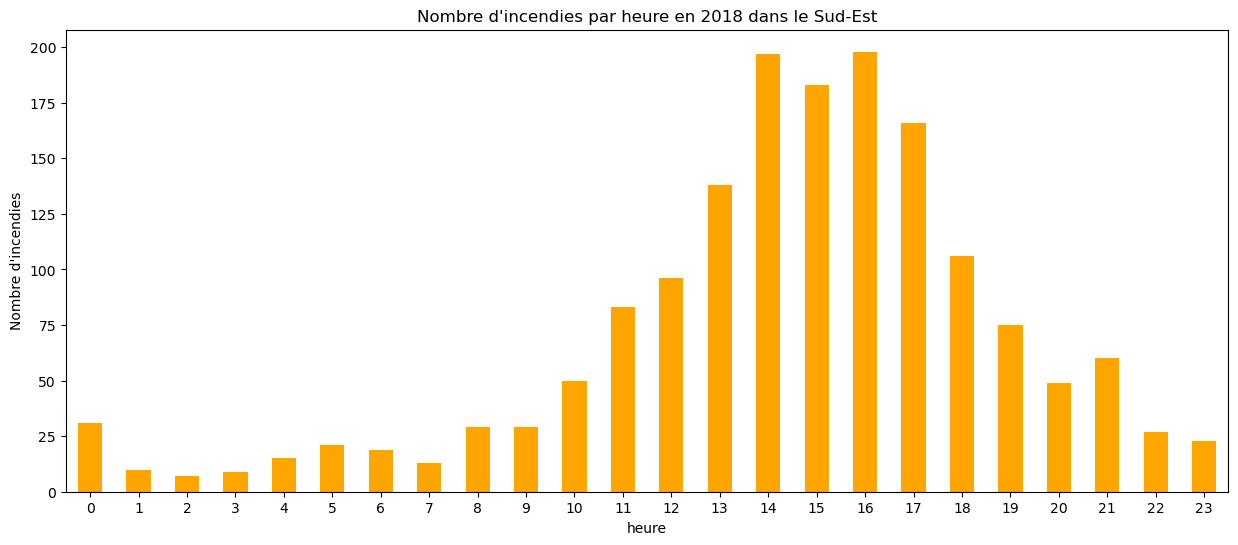

In [9]:
"histogramme du nombre d'incendies par mois"
plt.figure(figsize=(15, 6))
df_hist_incendies['mois'].value_counts().plot(kind='bar', color='orange')
plt.title('Nombre d\'incendies par mois en 2018 dans le Sud-Est')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'incendies')
plt.xticks(rotation=0)

"histogramme du nombre d'incendies par heure"
plt.figure(figsize=(15, 6))
df_hist_incendies['heure'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Nombre d\'incendies par heure en 2018 dans le Sud-Est')
plt.xlabel('heure')
plt.ylabel('Nombre d\'incendies')
plt.xticks(rotation=0)

plt.show()

<div align="justify">
En regardant l'occurence des incendies en 2018, on constate que les mois d'été connaissent bien plus d'incendies que les mois d'hiver et d'automne. Quant à l'heure, on remarque qu'un grand nombre d'incendies ont lieu dans l'après-midi. On peut supposer que cela est dû au climat d'été qui est d'avantage propice au déclenchement d'un feu de forêt. La variable heure qui correspond à l'heure du signalement de l'incendie doit vraisemblablement être proche de l'heure d'apparition du feu, on peut dire que les conditions climatiques dans l'après-midi sont plus favorables aux incendies que celles du matin ou de la nuit, ce sont les heures les plus chaudes de la journée. De plus la concentration des heures d'incendies dans l'après-midi peut être liée à la fréquentation qui semble jouer un rôle assez important puisque la plupart des incendies ont une cause non naturelle comme le montre le grahique suivant :

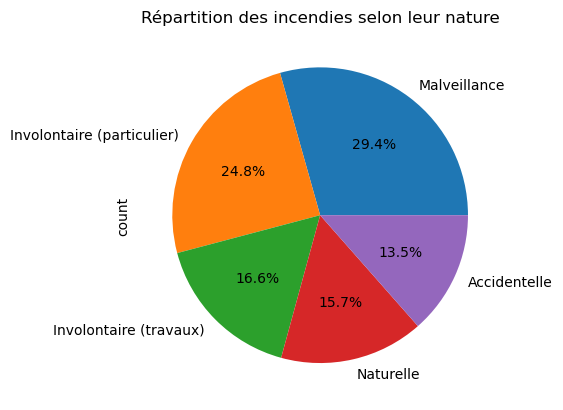

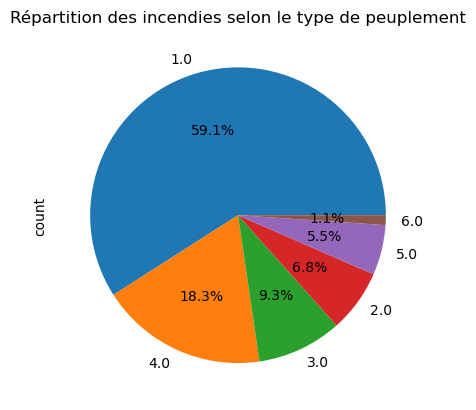

In [10]:
df_incendies['Nature'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Répartition des incendies selon leur nature")
plt.show()
df_incendies['Type de peuplement'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Répartition des incendies selon le type de peuplement")
plt.show()

En effet, 85% des incendies sont causés par l'homme. On observe également que certains types de peuplement c'est-à-dire une formation végétale spécifique sont plus touchés par les incendies. Le type de peuplement 1 qui représente 59% des incendies correspond aux Landes, garrigues et maquis, qui sont des végétations que l'on retrouve typiquement dans le Sud-Est de la France ou en Nouvelle-Aquitaine, régions les plus touchées par la problématiques des feux de forêts.  
Les autres types de peuplement sont dans l'ordre: taillis (2) / futaies feuillues (3) / futaies résineuses (4) / futaies mélangées (5) / régénération et reboisement (6).


### 2/ Base de données Meteonet

La base de données Meteonet est une base de données mise à disposition par Météo France pour encorager les projets de data science sur le thème de climat. Elle fournit en particulier des données météo au pas de 6 minutes pour 530 stations du quart Sud-Est de la France pendant 3 ans, de 2016 à 2018. Dans le cadre de ce projet nous nous sommes contentés d'utiliser les données pour l'année 2018.


Parmis ces données :

In [11]:
print(df_meteo_SE.columns)

Index(['number_sta', 'lat', 'lon', 'height_sta', 'date', 'dd', 'ff', 'precip',
       'hu', 'td', 't', 'psl'],
      dtype='object')


On retrouve des données spécifiques à la station :

<table>
<thead>
<tr>
<th>Nom</th>
<th>Description</th>
<th>Unité</th>
</tr>
</thead>
<tbody>
<tr>
<td>number_sta</td>
<td>ID de la station</td>
<td>-</td>
</tr>
<tr>
<td>lat</td>
<td>latitude</td>
<td>Degrés décimaux (10<sup>-1</sup> °)</td>
</tr>
<tr>
<td>lon</td>
<td>longitude</td>
<td>Degrés décimaux (10<sup>-1</sup> °)</td>
</tr>
<tr>
<td>height_sta</td>
<td>altitude de la station</td>
<td>mètres (m)</td>
</tr>
<tr>
<td>date</td>
<td> objet datetime</td>
<td>format 'YYYY-MM-DD HH: mm :ss'</td>
</tr>
</tbody>
</table>

et les données météorologiques

<table>
<thead>
<tr>
<th>Nom</th>
<th>Description</th>
<th>Unité</th>
</tr>
</thead>
<tbody>
<tr>
<td>dd</td>
<td>direction du vent</td>
<td>degrés (°)</td>
</tr>
<tr>
<td>ff</td>
<td>Vitesse du vent</td>
<td>m.s<sup>-1</sup></td>
</tr>
<tr>
<td>precip</td>
<td>Precipitations durant la période</td>
<td>kg.m<sup>2</sup></td>
</tr>
<tr>
<td>hu</td>
<td>Humidité</td>
<td>pourcentage (%)</td>
</tr>
<tr>
<td>td</td>
<td>Température de rosée*</td>
<td>Kelvin (K)</td>
</tr>
<tr>
<td>t</td>
<td>Température</td>
<td>Kelvin (K)</td>
</tr>
<tr>
<td>psl</td>
<td>Pression au niveau de lam mer</td>
<td>Pascal (Pa)</td>
</tr>
</tbody>
</table>

\* température de rosée : Le point de rosée ou température de rosée est la température sous laquelle de la rosée se dépose naturellement. Plus techniquement, en dessous de cette température qui dépend de la pression et de l'humidité ambiantes, la vapeur d'eau contenue dans l'air se condense sur les surfaces, par effet de saturation. (source Wikipedia)

Le code suivant permet de visualiser les différentes stations qu'offre le dataset :

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 91.6 MB/s eta 0:00:00:00:010:01


/opt/mamba/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/mamba/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


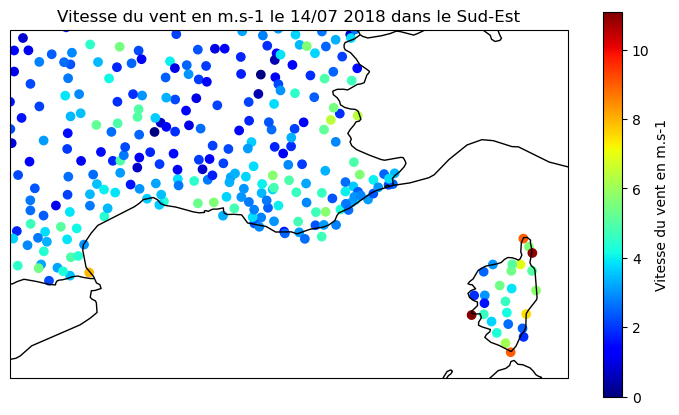

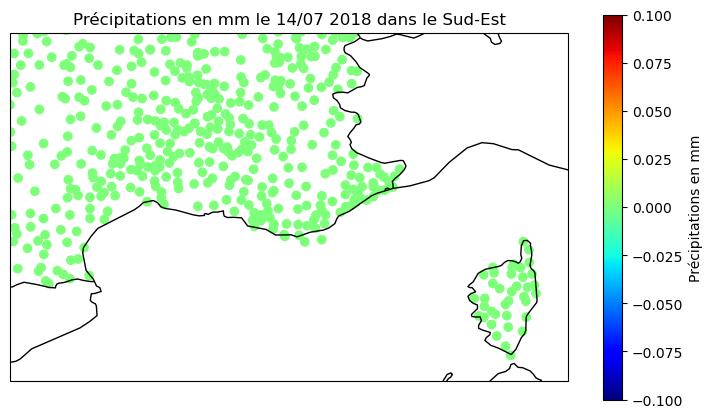

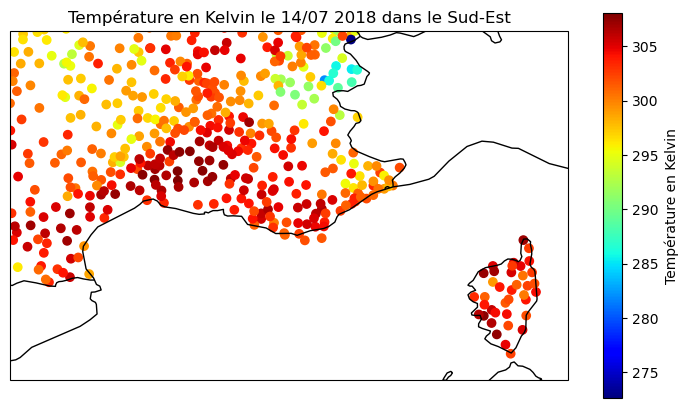

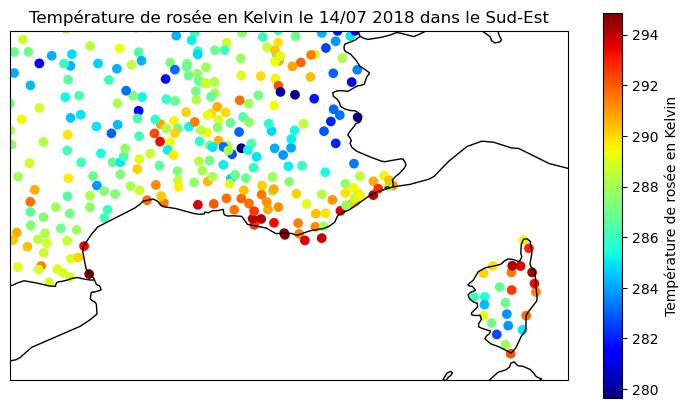

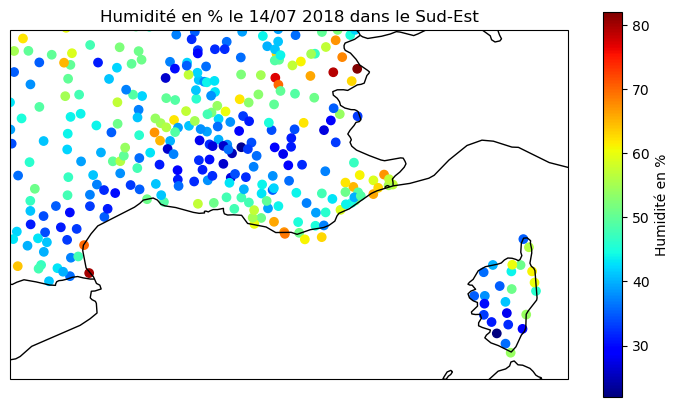

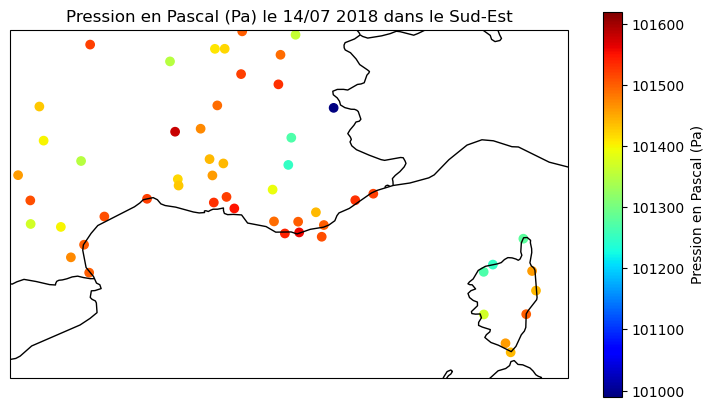

In [12]:
! pip install cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
date = "20180714 14:00"
dict_param = {'ff' : ['Vitesse du vent', 'm.s-1'],  'precip' : ['Précipitations', 'mm'], 't' : ['Température', 'Kelvin'], 
'td' : ['Température de rosée', 'Kelvin'], 'hu' : ['Humidité', '%'], 'psl' : ['Pression', 'Pascal (Pa)']} 
liste_param = dict_param.keys()
for param in liste_param : 
    nom_param, unite = dict_param[param]
    df = df_meteo_SE[df_meteo_SE['date'] == date]
    fenetre = [2, 10, 41, 46]
    #2, 41, 10, 45.5
    fig = plt.figure(figsize=(9,5))

    # on sélectionne une projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    #  on fait un scatter plot
    scatter = plt.scatter(df['lon'], df['lat'], c=df[param], cmap='jet')

    # on ajouter les bordures et les côtes
    ax.coastlines(resolution='50m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))

    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{nom_param} en {unite}')  # Mettez la description souhaitée pour la légende

    # on réduit au quart Sud-Est
    ax.set_extent(fenetre)
    # on ajoute un titre
    plt.title(f"{nom_param} en {unite} le {date[6:8]}/{date[4:6] } 2018 dans le Sud-Est")
    plt.show()



- Pour la vitesse du vent : on voit que là où il y  le vent le plus fort c'est au niveau des côtes et c'est également là où la densité d'incendie est la plus élévée si l'on regarde la carte de la partie précédente. Il se peut que la vitesse du vent joue effectivement un rôle.
- pour les précipitations : elles sont quasiment partout autour de 0 mm, cela est dû sans doute à la date que nous  avons choisi pour l'exemple, qui se trouve être en plein été
- Pour les températures : elles sont très élévées, avec un léger gradient vers le sud, et plus faible logiquement en altitude.
- Pour l'humidité : on remarque que logiquement les zones littorales sont les plus humides et que dès que l'on avance un peu dans l'arrière pays le % d'humidité décroit fortement.
-Pour ce qu est de la pression ramennée au niveau de la mer, les tendances spatiales sont difficiles à interpréter du fait de qu'il y a très peu de relevés.




## II] Création de la base de données finale


Maintenant que nous avons vu les bases de données que nous allons utiliser nous allons passer à l'étape suivante : manipuler les bases de données pour créer une base de donnée finale que l'on notera `df_final`.  
Cette base de données `df_final` sera composée des variables que l'on peut qualifier d'explicatives, i.e. les données météorologiques journalières pour chacune des communes du Sud-Est de la France, ainsi que de la variable cible (ou target en anglais) à savoir : présence ou non d'un incendie dans la commune ce jour.

**Obtenir les données météo journalières :** Les données du dataset de Météo France sont données toutes les 6 minutes pour chaque station sur l'ensemble de l'année. Nous avons donc décidé de les moyenner sur la journée afin réduire le nombre d'observations à une par jour et par station. Choisir la moyenne (au  lieu, du  max ou de la médiane par exemple) est un choix arbitraire, cependant la moyenne est une statistique qui capte la tendance globale de la journée tout en gardant une sensibilité aux valeurs extrêmes ce qui parait judicieux dans notre cas.  
C'est donc le sens de ce dataframe `df_meteo_moy`.

In [13]:
df_meteo_SE['date'] = pd.to_datetime(df_meteo_SE['date'])
df_meteo_moy = df_meteo_SE.groupby(['number_sta', pd.Grouper(key = 'date', freq = 'D')]).mean().reset_index()
display(df_meteo_moy.head())

,number_sta,date,lat,lon,height_sta,dd,ff,precip,hu,td,t,psl
0,1027003,2018-01-01,45.83,5.11,196.0,NaN,NaN,NaN,80.679167,277.326250,280.587917,NaN
1,1027003,2018-01-02,45.83,5.11,196.0,NaN,NaN,NaN,76.962343,276.310084,280.177311,NaN
2,1027003,2018-01-03,45.83,5.11,196.0,NaN,NaN,NaN,80.033333,278.724167,282.273333,NaN
3,1027003,2018-01-04,45.83,5.11,196.0,NaN,NaN,NaN,93.241667,281.604583,282.673333,NaN
4,1027003,2018-01-05,45.83,5.11,196.0,NaN,NaN,NaN,82.687500,281.308333,284.290833,NaN


- On va ensuite vouloir associer à chaque commune la station météorologique la plus proche pour pouvoir avoir accès à la météo journalière de la commune en question. Pour cela on a besoin de calculer la distance entre la position GPS de la commune et celle de la station météo, on utilise donc cette fonction : 

In [14]:
def distance(lat1,lon1,lat2,lon2):
    """ 
    INPUT : les coordonnées GPS de deux points
    
    OUTPUT : la distance entre ces deux points à vol d'oiseau
    """
    return 6371*np.arccos(np.sin(lat1*np.pi/180)*np.sin(lat2*np.pi/180)+np.cos(lat1*np.pi/180)*np.cos(lat2*np.pi/180)*np.cos((lon2-lon1)*np.pi/180))


Cependant `df_meteo_moy` ne contient pas d'information sur la commune où se trouve la station. Nous allons donc devoir faire appelle à une nouveau dataframe appelé `df_commune` qui contient les codes communes INSEE ainsi que les coordonnées GPS des communes.

 La cellule suivante permet de d'obtenir pour chaque commune la station météo la plus proche en distance. Pour chaque commune on calcule la distance à chaque station et puis on séléctionne celle qui a la distance la plus faible.

In [15]:
plus_proche_station = np.zeros(len(df_communes))
for i in df_communes.index : 
    lat1 = df_communes.lat[i]
    lon1 = df_communes.lon[i]
    d_min = 100
    index_min = 0
    for j in df_stations_SE.index : 
        lat2 = df_stations_SE.lat[j]
        lon2 = df_stations_SE.lon[j]
        d = distance(lat1,lon1,lat2,lon2) 
        if d <= d_min :
            d_min = d
            index_min = j

    plus_proche_station[i] = df_stations_SE.number_sta[index_min]



 On va ensuite commencer la création du dataframe final ` df_final` en associant à chaque commune sa météo jounalière :

In [16]:
df_final = df_communes

df_final['number_sta'] = pd.DataFrame(plus_proche_station.astype(int))

df_meteo_moy = df_meteo_moy.rename(columns={'lat' : 'lat_sta', 'lon' : 'lon_sta'})

df_final = df_final.merge(df_meteo_moy, on = 'number_sta', how = 'left')

df_final['date'] = pd.to_datetime(df_final['date'])

display(df_final.head(10))


,index,code_commune_INSEE,lat,lon,region,number_sta,date,lat_sta,lon_sta,height_sta,dd,ff,precip,hu,td,t,psl
0,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-05,46.038,5.044,280.0,NaN,NaN,0.000000,NaN,NaN,281.837879,NaN
1,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-14,46.038,5.044,280.0,NaN,NaN,0.000000,NaN,NaN,272.222642,NaN
2,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-15,46.038,5.044,280.0,NaN,NaN,0.006667,NaN,NaN,273.077083,NaN
3,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-16,46.038,5.044,280.0,NaN,NaN,0.008333,NaN,NaN,277.585000,NaN
4,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-17,46.038,5.044,280.0,NaN,NaN,0.011667,NaN,NaN,277.890417,NaN
5,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-18,46.038,5.044,280.0,NaN,NaN,0.000833,NaN,NaN,278.067917,NaN
6,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-19,46.038,5.044,280.0,NaN,NaN,0.052500,NaN,NaN,280.643333,NaN
7,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-20,46.038,5.044,280.0,NaN,NaN,0.000000,NaN,NaN,279.035000,NaN
8,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-21,46.038,5.044,280.0,NaN,NaN,0.025833,NaN,NaN,281.076667,NaN
9,0,01001,46.153426,4.926114,Auvergne-Rhône-Alpes,1235001,2018-12-22,46.038,5.044,280.0,NaN,NaN,0.000000,NaN,NaN,283.481667,NaN


Pour finaliser notre base de donnée en vue de lui appliquer des algorithmes de régression, il nous faut maintenant ajouter une colonne "incendie" qui prend la valeur 1 s'il y a eu un incendie déclaré ce jour dans la commune et 0 sinon : 

In [17]:
# Ajustements sur le dataframe incendie en vue de la jointure avec la base finale
df_incendies['Date de première alerte'] = pd.to_datetime(df_incendies['Date de première alerte'])
df_incendies['date'] = df_incendies['Date de première alerte'].dt.date
df_incendies = df_incendies.rename(columns={'Code INSEE' : 'code_commune_INSEE'})
df_incendies_18 = df_incendies[df_incendies['Année'] == 2018]

In [18]:
df_final['date'] = df_final['date'].dt.date

df_final = pd.merge(df_final, df_incendies_18, how='left', on=['date', 'code_commune_INSEE'])

colonnes_a_verifier = ["Origine de l'alerte",
       'Moyens de première intervention', 'Surface parcourue (m2)',
       'Surface forêt (m2)', 'Surface maquis garrigues (m2)',
       'Autres surfaces naturelles hors forêt (m2)', 'Surfaces agricoles (m2)',
       'Autres surfaces (m2)', 'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces',
       "Surface de feu à l'arrivée des secours > 0,1 ha",
       'Voie carrossable la plus proche',
       'Activité ou habitation la plus proche', 'Type de peuplement',
       'Connaissance', "Source de l'enquête", 'Nature',
       "Intervention de l'équipe RCCI", 'Décès ou bâtiments touchés',
       'Nombre de décès', 'Nombre de bâtiments totalement détruits',
       'Nombre de bâtiments partiellement détruits', 'Hygrométrie (%)',
       'Vitesse moyenne du vent (Km/h)', 'Direction du vent',
       'Température (°C)', 'Précision de la donnée',
       "Présence d'un contour valide"]  
       
# Si sur une même ligne toutes les valeurs colonnes relatives à l'incendie sont "nan" c'est qu'il n'y a eu d'incendie

df_final['incendie'] = 1-df_final[colonnes_a_verifier].isna().all(axis=1).astype(int)

display(df_final.sample(10))

,index,code_commune_INSEE,lat,lon,region,number_sta,date,lat_sta,lon_sta,height_sta,...,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée,Présence d'un contour valide,incendie
8287,26,01029,46.428836,5.260034,Auvergne-Rhône-Alpes,1072001,2018-10-16,46.204,5.288,260.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
679796,3932,11043,43.232346,2.444109,Occitanie,11081003,2018-06-19,43.334,2.481,371.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2358070,13272,32041,43.426994,0.632110,Occitanie,1027003,2018-02-20,45.830,5.110,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2813129,14563,34290,43.710749,3.876897,Occitanie,34217001,2018-05-29,43.717,3.858,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1217417,6380,17066,45.475026,-0.300809,Nouvelle-Aquitaine,1027003,2018-11-02,45.833,5.107,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
334204,1923,05078,44.393096,5.933972,Provence-Alpes-Côte d'Azur,5170001,2018-10-17,44.452,6.033,600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2164610,12735,31099,43.319833,1.707268,Occitanie,11181002,2018-02-10,43.390,2.020,408.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2558675,13836,33128,45.343773,-0.916117,Nouvelle-Aquitaine,1027003,2018-09-27,45.833,5.107,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3988036,28422,65106,42.831672,0.341937,Occitanie,1027003,2018-08-17,45.833,5.107,196.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4418453,32424,74140,46.255524,6.473244,Auvergne-Rhône-Alpes,74191003,2018-03-31,46.168,6.693,1515.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


On va effectuer quelques vérifications pour voir si l'on a pas loupé des incendies, par exemple :

In [19]:
diff = list(set(df_incendies_18['code_commune_INSEE'])-set(df_final[df_final['incendie']== 1]['code_commune_INSEE']))
print("codes commune INSEE de communes ayant eu des incendies n'apparaissant pas dans la table finale :\n",diff)
print(f"Ils sont au nombre de {len(diff)}.")

codes commune INSEE de communes ayant eu des incendies n'apparaissant pas dans la table finale :
 ['72231', '66115', '72357', '50267', '48137', '36150', '72363', '83126', '45040', '45204', '72217', '71294', '45182', '68375', '74012', '72003', '48022', '84032', '07024', '12177', '77333', '2A131', '07266', '50412', '48172', '88438', '13055', '72058', '45082', '48095', '2A026', '2B337', '48121', '21548', '43082', '84078', '88410', '72053', '72382', '48066', '11206', '73225', '72264', '58149', '45272', '24118', '2B328', '11008', '72008', '2A330', '2A272', '36207', '21032', '88160', '66024', '72298', '45223', '72047', '49209', '13092', '48147', '72187', '88243', '2B220', '2B201', '83051', '74016', '72100', '88107', '36189', '77186', '48146', '12088', '35219', '49101', '72260', '46019', '21445', '2A129', '72213', '72329', '72051', '76259', '74133', '11355', '58187', '72346', '66178', '72232', '72181', '84017', '2A308', '2B364', '72223', '50516', '36178', '2A160', '66065', '72154', '61172', '

Comme on peut le constater avec les deux premiers chiffres de ces codes communes INSEE qui correspondent au département, les départements où se situent ces communes ne sont pas des départements du Sud-Est et donc leurs feux de forêts n'entre pas dans le cadre de notre étude.  
Pour les  quelques exeptions qui restent, nous avons conclu après vérification dans la base de données de la météo qu'il s'agit en fait de ville où les données météo ne sont pas disponibles le jour de l'incendie. 

Maintenant que nous avons notre base de données finale nous allons pouvoir nous lancer dans l'analyse exploratoire des données.

# III] Analyse exploratoire des données

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from datetime import datetime

In [21]:
data = df_final
data.shape

(5017137, 54)

La base de donnée compte donc 5 017 137 lignes et 54 colonnes, le but de l'analyse qui suit va être de savoir lesquelles semblent pertinentes  et lesquelles il faut enlever.

### 1/Analyse de la forme des données

In [22]:
df = data.copy()

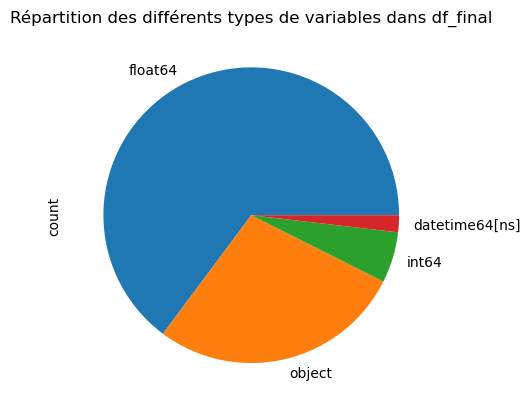

In [23]:
df.dtypes.value_counts().plot.pie()
plt.title('Répartition des différents types de variables dans df_final')
plt.show()

Le camembert ci-dessus montre les différents types de variables présents dans la base de données. Nous déduisons de ces types que nous avons à la fois des variables qualitatives et des variables quantitatives.

### 2/ Données manquantes

<Axes: >

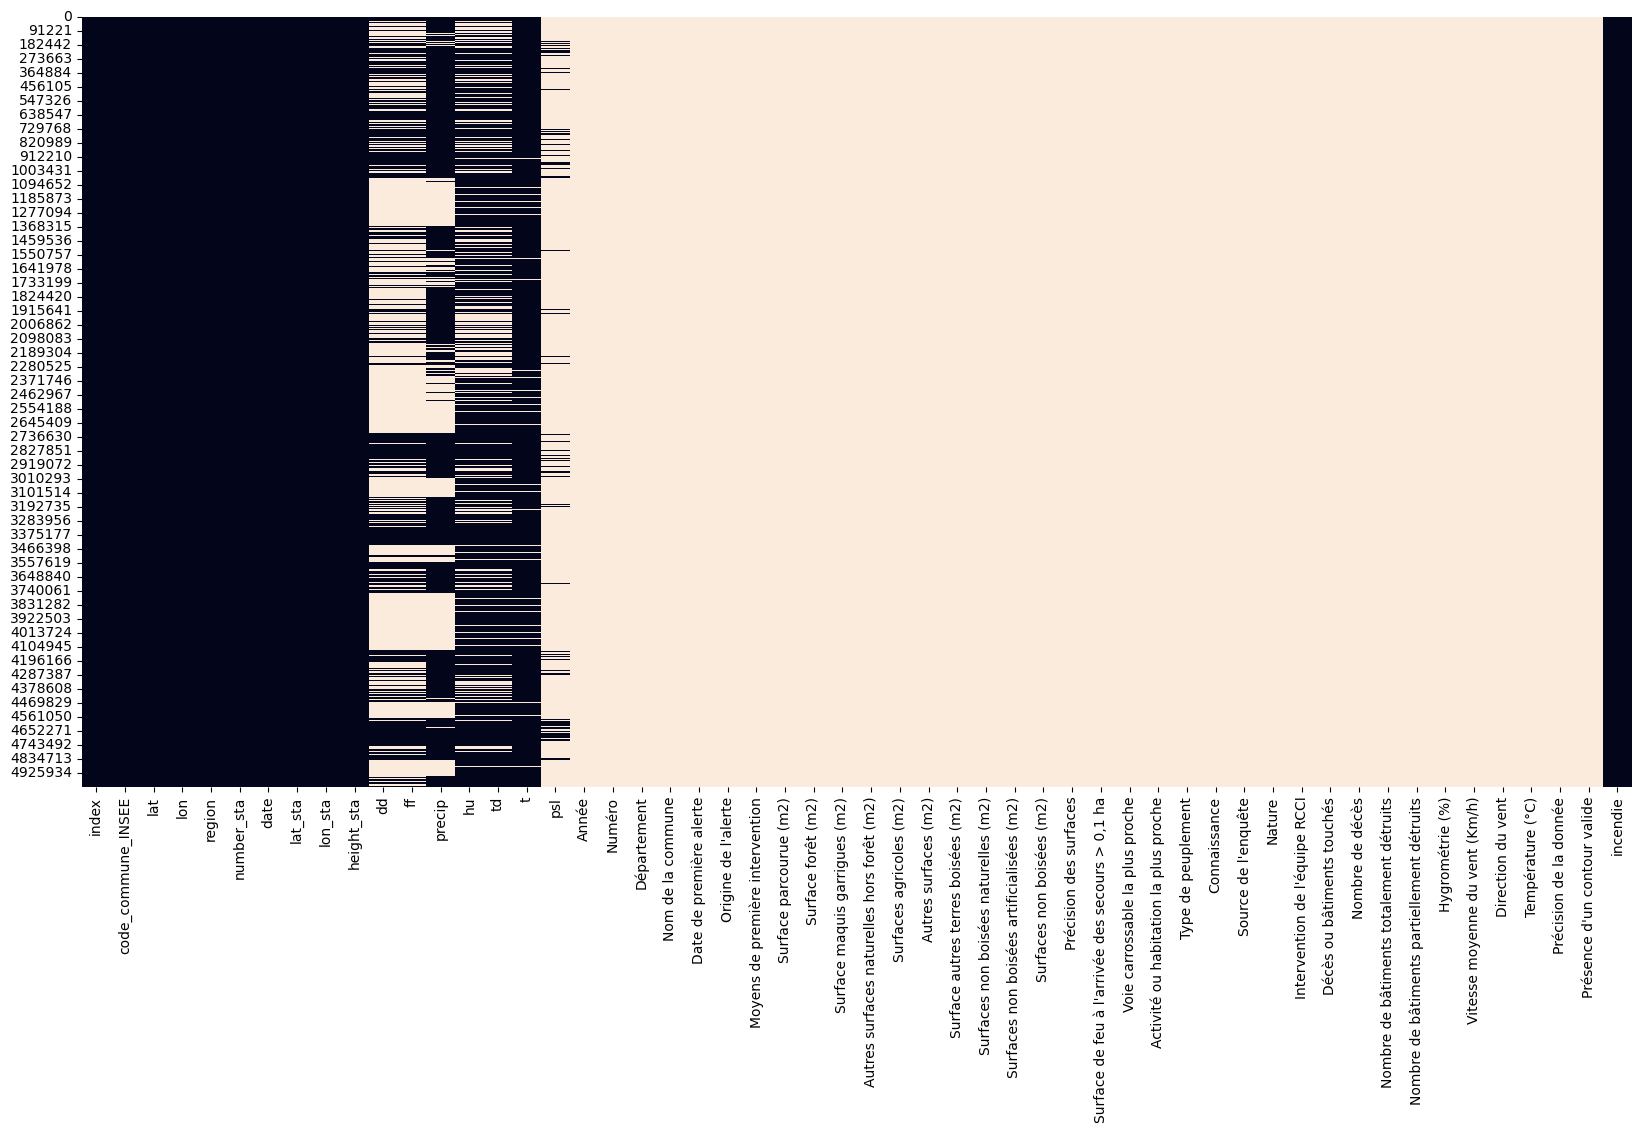

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

Sur cette heatmap, on a en noir les valeurs bien présentes et en beige les valeurs NaN manquantes. On remarque que certains colonnes semblent ne contenir que des NaN. 
Regardons plus en détail le taux de valeurs manquantes par colonnes :
 

In [ ]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

index                                              0.000000
code_commune_INSEE                                 0.000000
lat                                                0.000000
lon                                                0.000000
region                                             0.000000
number_sta                                         0.000000
date                                               0.000000
lat_sta                                            0.000000
lon_sta                                            0.000000
height_sta                                         0.000000
incendie                                           0.000000
t                                                  0.038089
hu                                                 0.242230
td                                                 0.242340
precip                                             0.332814
ff                                                 0.585039
dd                                      

Toutes les colonnes provenant de la base de données incendie ne sont en fait remplies que lorsqu'il y a un incendie (elle ne sont pas présentes dans la base météo France). En vue de la modélisation et de la recherche des variables météo influençant le risque d'incendie, elles sont donc inexploitables.

## Analyse du Fond
### 1/ Visulation initiale - Elimination des colonnes inutiles

On peut à présent nettoyer la base en excluant les variables pour lesquelles on ne dispose de presque aucune valeur (i.e celles pour lesquelles le taux de valeurs manquantes Nan est supérieur à 99%). Cela supprime les variables de la base incendies et conserve les variables météorologiques bien que certaines grandeurs comme la pression (psl) ont beaucoup de valeurs manquantes (plus de 90%).

In [ ]:
df = df[df.columns[df.isna().sum()/df.shape[0] <0.99]]
df.head()
df.shape

(5017137, 18)

Nous affichons désormais la nouvelle heatmap des NaN de cette base de données épurée.

<Axes: >

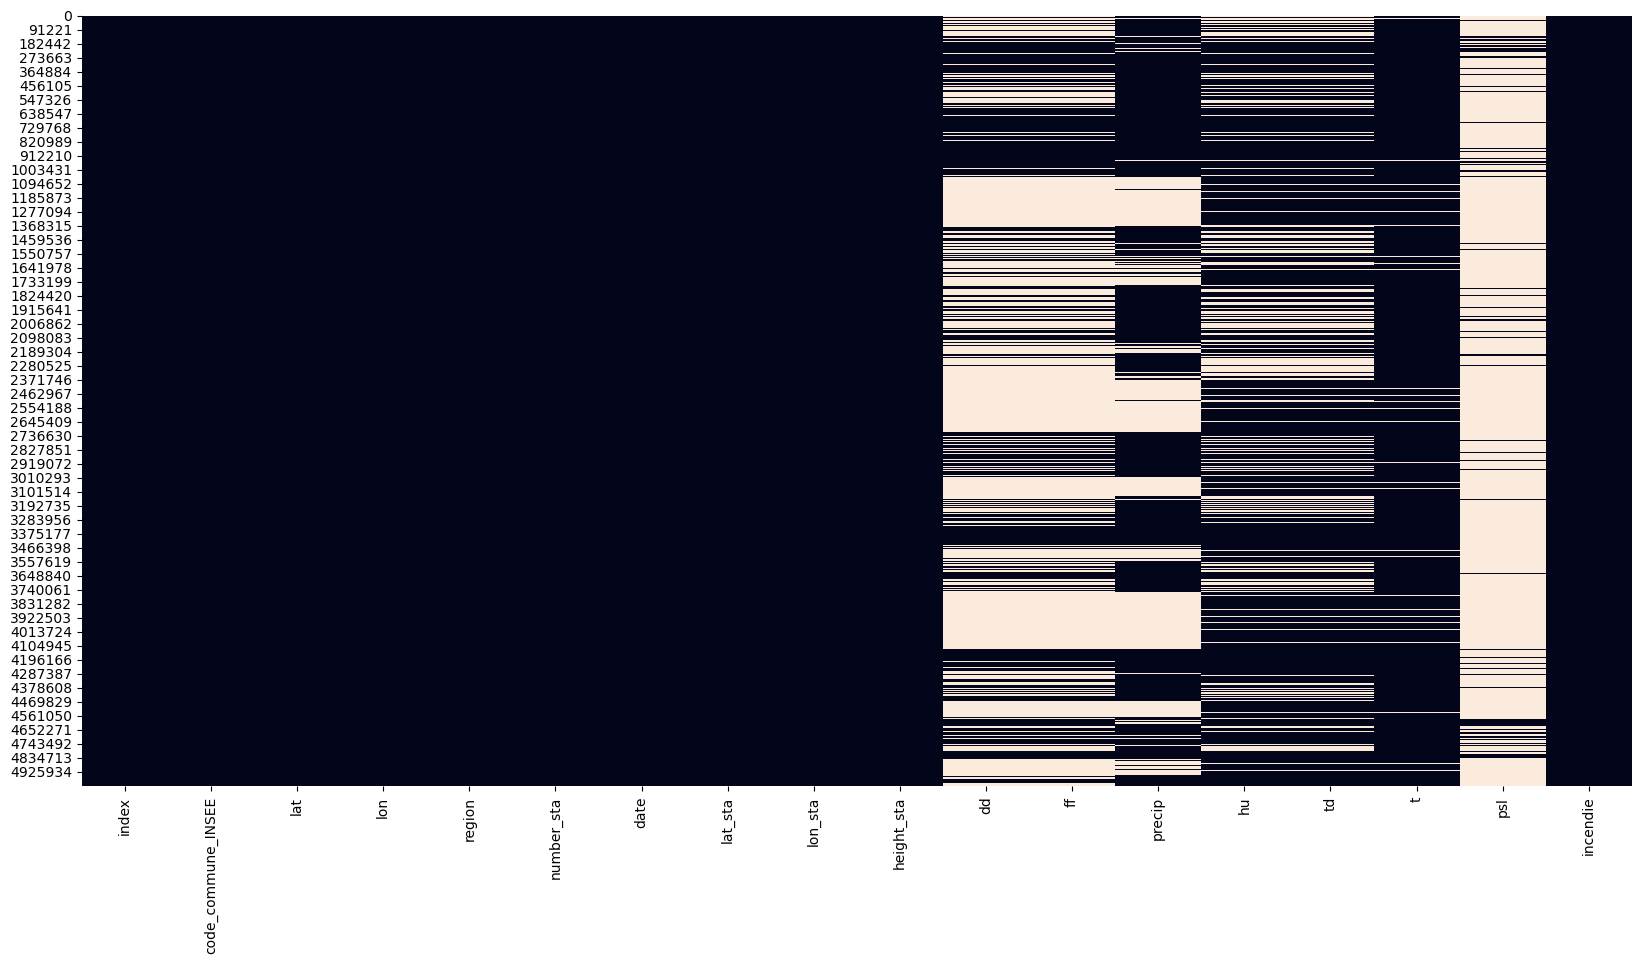

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

Le data frame est quasiment prêt. Puisqu'on a associé chaque incendie à une commune et aux données météorologiques moyennes du jour d'apparition de l'incendie, il n'est plus nécessaire de garder les coordonnées géographiques, le numéro de la station, l'index.

In [ ]:
df=df.drop(['index','lat','lon','lat_sta','lon_sta','height_sta', 'number_sta'], axis=1)
display(df.head())

,code_commune_INSEE,region,date,dd,ff,precip,hu,td,t,psl,incendie
0,01001,Auvergne-Rhône-Alpes,2018-12-05,NaN,NaN,0.000000,NaN,NaN,281.837879,NaN,0
1,01001,Auvergne-Rhône-Alpes,2018-12-14,NaN,NaN,0.000000,NaN,NaN,272.222642,NaN,0
2,01001,Auvergne-Rhône-Alpes,2018-12-15,NaN,NaN,0.006667,NaN,NaN,273.077083,NaN,0
3,01001,Auvergne-Rhône-Alpes,2018-12-16,NaN,NaN,0.008333,NaN,NaN,277.585000,NaN,0
4,01001,Auvergne-Rhône-Alpes,2018-12-17,NaN,NaN,0.011667,NaN,NaN,277.890417,NaN,0


### 2/Examen de la colonne incendie
Peu de jours avec incendie, la métrique d'évaluation du modèle devra en prendre compte

In [ ]:
df['incendie'].value_counts(normalize=True)

incendie
0    0.999713
1    0.000287
Name: proportion, dtype: float64

In [ ]:
df['incendie'].sum()

1442

### 3/Graphiques des variables continues 

Tout d'abord, convertissons les températures en delgré Celsius

In [ ]:
df['t']=df['t']-273.15
df['td']=df['td']-273.15

#### distribution des variables météorologiques 

In [ ]:
import warnings
warnings.filterwarnings('ignore', category = UserWarning)

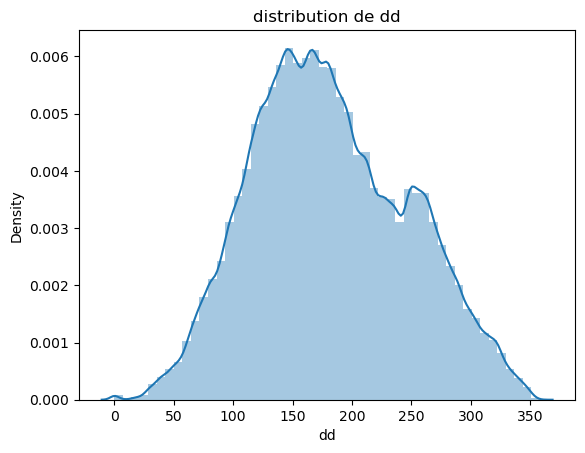

In [ ]:
"distribution de dd"
plt.figure()
sns.distplot(df['dd'])
plt.title("distribution de dd")
plt.show()

La direction du vent (en degrés) a une distribution continue, elle semble un peu étalée à droite.

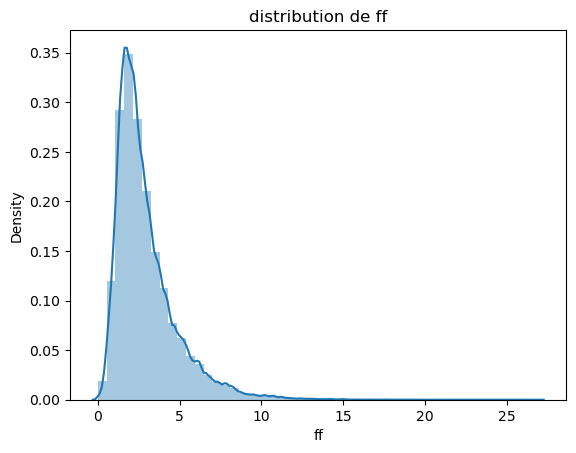

In [ ]:
"distribution de ff"
plt.figure()
sns.distplot(df['ff'])
plt.title("distribution de ff")
plt.show()

La force du vent en (m/s) a également une distribution continue, positive et étalée à droite. Elle ressemble à une distribution de loi Gamma pour certains paramètres.

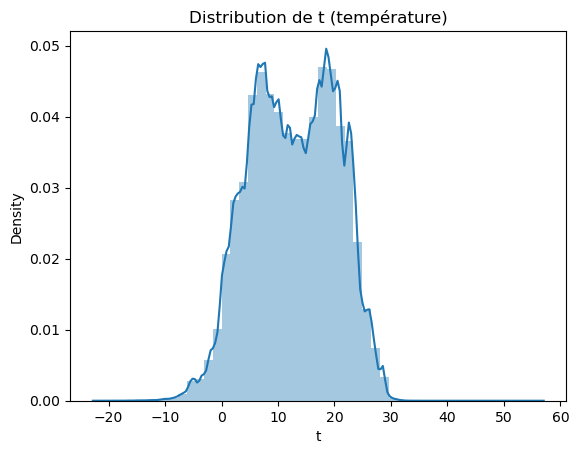

In [ ]:
"distribution de t"
plt.figure()
sns.distplot(df['t'])
plt.title("Distribution de t (température)")
plt.show()

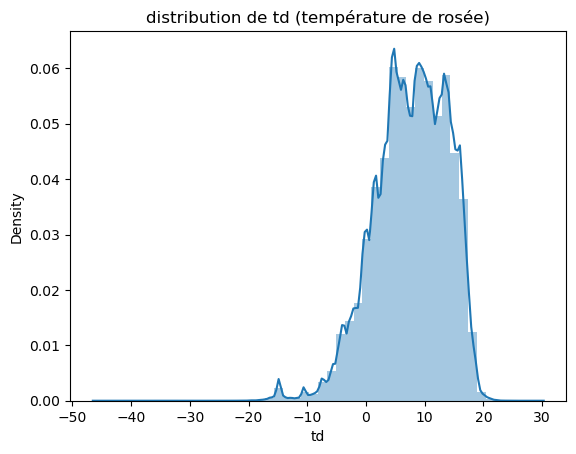

In [ ]:
"distribution de td"
plt.figure()
sns.distplot(df['td'])
plt.title('distribution de td (température de rosée)')
plt.show()

Les températures moyenne sur la journée (t) et de rosée (td) sont exprimées en degrés celsius et ont une distribution continue n'ayant pas la forme d'une distribution classique. Elles ont plusieurs pics de densité, ce qui fait penser à un modèle de mélange (où les plusieurs populations seraient les différentes saisons).

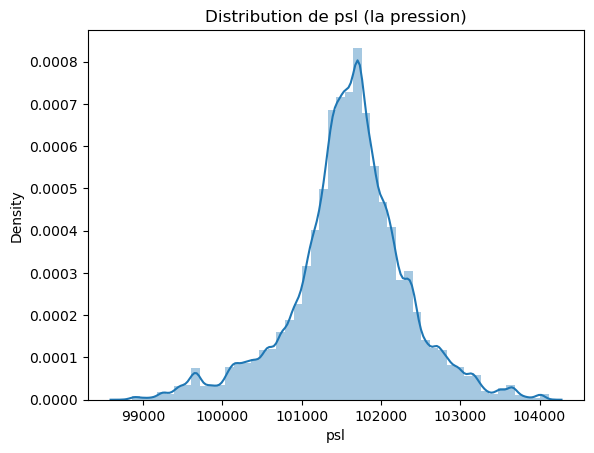

In [ ]:
"distribution de psl"
plt.figure()
sns.distplot(df['psl'])
plt.title('Distribution de psl (la pression)')
plt.show()

La pression (en pascal) est continue, et a une forme de distribution gaussienne. C'est la variable qui semble le plus être distribuée normalement.

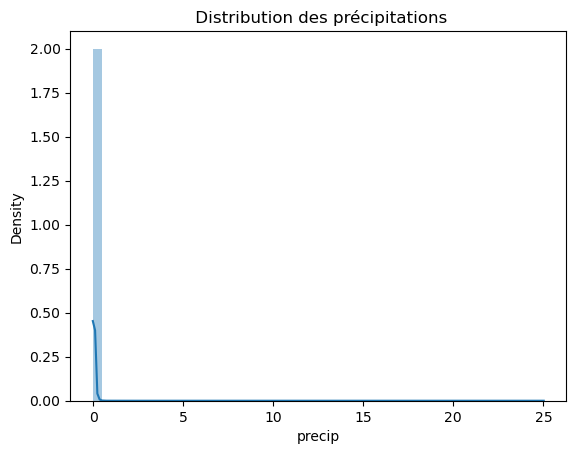

In [ ]:
"distribution de precip"
plt.figure()
sns.distplot(df['precip'])
plt.title(' Distribution des précipitations')
plt.show()

la précipitation (en kg.m^2) n'est ni continue, ni discrète. Il met de la masse sur 0 (il y a une part significative des jours où il ne pleut pas) et est ensuite diffuse sur les valeurs strictement positive.

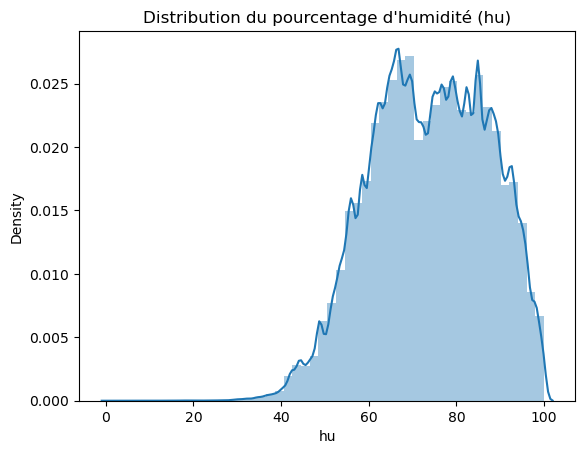

In [ ]:
"distribution de hu"
plt.figure()
sns.distplot(df['hu'])
plt.title("Distribution du pourcentage d'humidité (hu)")
plt.show()

L'humidité (en "pourcentage %") est continue, ne ressemble pas à une distribution connue. On observe deux pics principaux, ce qui fait penser à un modèle de mélange comme pour la température.

### 3/Variables Qualitatives

In [ ]:
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

code_commune_INSEE-------------------------------- ['01001' '01002' '01004' ... '87204' '87205' '87206']
region-------------------------------------------- ['Auvergne-Rhône-Alpes' "Provence-Alpes-Côte d'Azur" 'Occitanie'
 'Nouvelle-Aquitaine' 'Corse']
date---------------------------------------------- [datetime.date(2018, 12, 5) datetime.date(2018, 12, 14)
 datetime.date(2018, 12, 15) datetime.date(2018, 12, 16)
 datetime.date(2018, 12, 17) datetime.date(2018, 12, 18)
 datetime.date(2018, 12, 19) datetime.date(2018, 12, 20)
 datetime.date(2018, 12, 21) datetime.date(2018, 12, 22)
 datetime.date(2018, 12, 23) datetime.date(2018, 12, 24)
 datetime.date(2018, 12, 25) datetime.date(2018, 12, 26)
 datetime.date(2018, 12, 27) datetime.date(2018, 12, 28)
 datetime.date(2018, 12, 29) datetime.date(2018, 12, 30)
 datetime.date(2018, 12, 31) datetime.date(2018, 1, 1)
 datetime.date(2018, 1, 2) datetime.date(2018, 1, 3)
 datetime.date(2018, 1, 4) datetime.date(2018, 1, 5)
 datetime.date(2018, 1, 

### 4/ Relation Target / Variables
 Création de sous-ensembles positifs et négatifs

In [ ]:
incendie_df = df[df['incendie'] == 1]
no_incendie_df = df[df['incendie'] == 0]


### 5/ Distributions des variables météorologiques pour les jours d'incendies et les jours sans incendies

Nous allons désormais tracer les distributions des variables météo conditionnellement à la valeur de la variable incendie. Ceci nous permettra d'observer s'il y a des différences moyennes entre le groupe des données d'incendie, et le groupe des données sans incendie

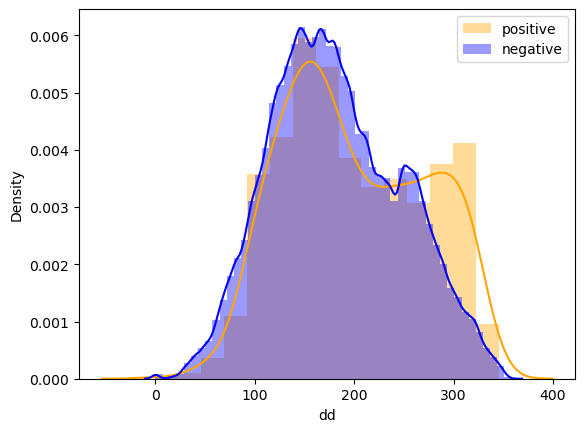

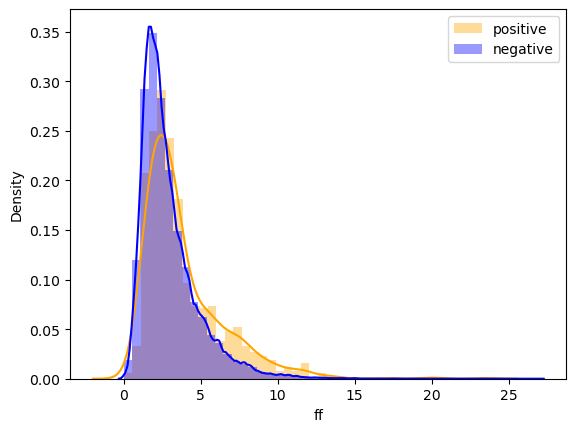

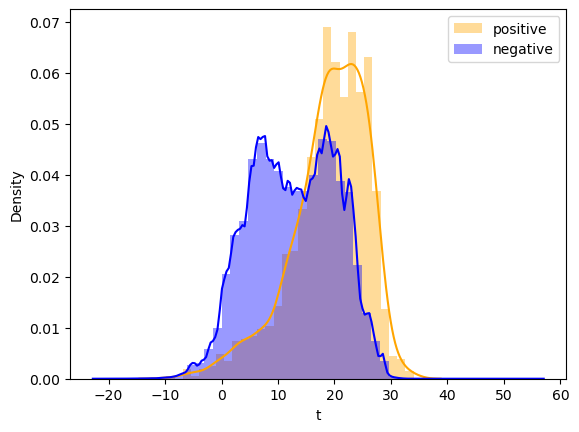

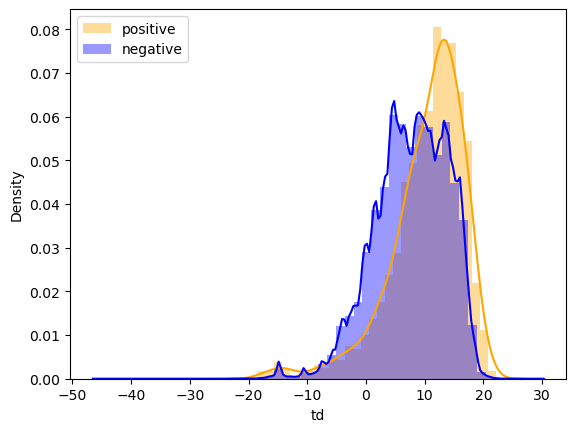

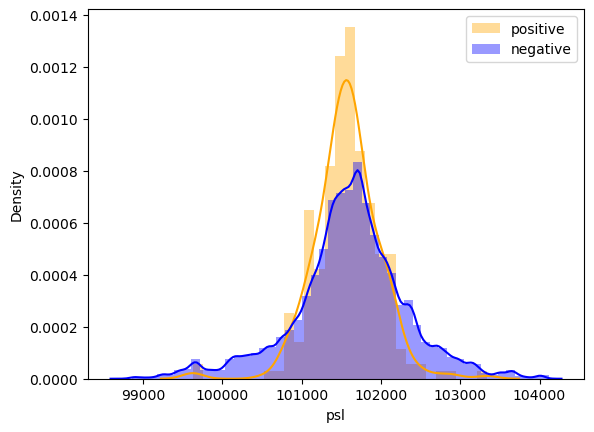

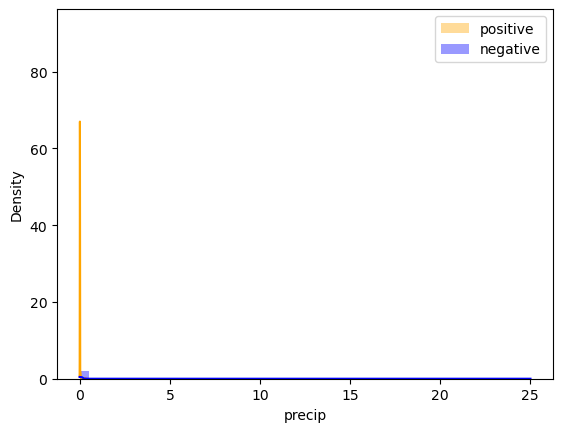

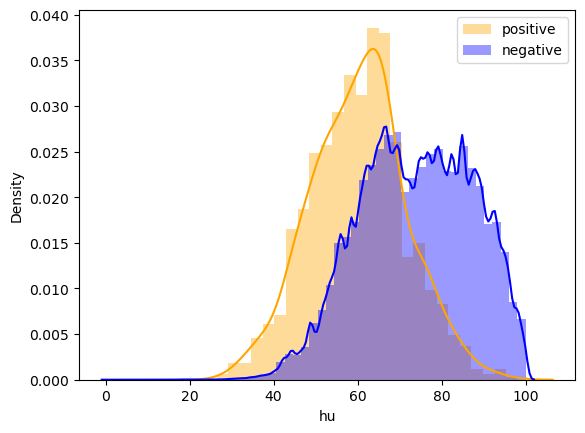

In [ ]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    plt.figure()
    sns.distplot(incendie_df[col], label='positive', color='orange')
    sns.distplot(no_incendie_df[col], label='negative', color='blue')
    plt.legend()

<div align="justify">
Lorsqu'on compare les distributions des deux groupes, il semblerait que les températures et les températures de rosée des jours d'incendie soient soient en moyenne plus élevées de celles des jours sans incendie. De même, l'humidité paraît en moyenne plus basse quand il y a un incendie.
La différence de distribution de la direction du vent n'est pas significative. La vitesse du vent quant à elle semble être très légèrement élevée lorsqu'il y a un incendie mais cela n'est pas clair.
On n'observe pas de différence moyenne pour la pression. La distribution semble cependant moins étalée lorsqu'il y a un incendie.
On voit qu'il n'y a systématiquement pas de pluie sur les jours d'incendie (precip=0).

Il faudra alors effectuer des tests pour vérifier si effectivement les distributions des variables météorologiques sont différentes pour les deux groupes.

### 6/ T-Test

Le test le plus utilisé pour comparer des différences moyennes entre groupes est le t-test. Ici on utilise tire aléatoirement parmi le données sans incendies le même nombre de données que le nombre de données avec incendie. Ceci permet d'avoir un test qui s'exécute assez rapidemenet et les échantillons peuvent être considérés indépendants. On ajoute l'option equal_var = False, car les distributions conditionnelles n'ont pas nécessairement la même variance.

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
balanced_neg = no_incendie_df.sample(incendie_df.shape[0])

In [ ]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    stat, p = ttest_ind(balanced_neg[col].dropna(), incendie_df[col].dropna(), equal_var=False)

    print(col,p)

dd 3.1083557036846175e-08
ff 4.0604484018766886e-14
t 7.09517579577471e-111
td 5.156521233678878e-24
psl 0.19333577326154938
precip 2.0015018454229431e-10
hu 2.7676812994173007e-128


On voit que le test trouve des différences moyennes significativement différentes pour toutes les variables météo sauf pour la pression (psl) et la précipitation (precip).
Cependant, comme vu sur les histogrammes précédents, l'hypothèse de normalité des distributions conditionnelles n'est pas vérifiée.
Ceci est particulièrement le cas pour la variable précipitation n'est pas distribuée normalement (même conditionellement à l'incendie) donc les hypothèses du t-test ne sont pas vérifiées. 
Nous allons alors faire un test non paramétrique: celui de Mann Whitney.

### 7/ Test de Mann Whitney

Le test de Mann Whitney teste si les médianes des distributions sont les mêmes. Ce test est une alternative non-paramétrique au t-test. Il fait des hypothèses très faibles sur les distributions des échantillons.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    stat, p = mannwhitneyu(balanced_neg[col].dropna(), incendie_df[col].dropna())
    print(col,p)

dd 7.656341296482985e-07
ff 5.009661462214794e-13
t 1.5766874264048543e-104
td 2.1426923259702583e-32
psl 0.8937302596306353
precip 3.265558067633748e-38
hu 2.1398907091773557e-111


 On trouve les mêmes significativité de la différence moyenne/médiane des variables météorologiques selon qu'il y ait un incendie ou non. Cependant pour la précipitation, le test de Mann Whitney trouve une différence médiane significative qui n'était pas trouvée par le t-test. Le test de Mann Whitney est plus robuste compte tenu des hypothèses de normalité qui ne sont pas respectées. Un autre test est celui de la corrélation de Pearson qui étudie si la corrélation entre la variable incendie et la variable météorologique est significativement différente de 0, à noter que lorsqu'une des deux variables est binaire on appelle cette corrélation la corrélation du point bisériel.

### 8/ Test de corrélation de Pearson

In [ ]:
from scipy.stats import pearsonr

# Calcul de la corrélation de point bisériel
for col in ['dd','ff','t','td','psl','precip','hu']:
    dfcol=df[[col,'incendie']].dropna()
    corr, p_value = pearsonr(dfcol[col], dfcol['incendie'])
    print(col)
    print('Coefficient de corrélation de point bisériel:', corr)
    print('P-value:', p_value)


dd
Coefficient de corrélation de point bisériel: 0.006095784140236118
P-value: 1.4256413702914027e-18
ff
Coefficient de corrélation de point bisériel: 0.010427608785240294
P-value: 3.6540255121840905e-51
t
Coefficient de corrélation de point bisériel: 0.014264388850828461
P-value: 1.4196961600661673e-215
td
Coefficient de corrélation de point bisériel: 0.007871010464071362
P-value: 3.7525651714066733e-53
psl
Coefficient de corrélation de point bisériel: -0.0010460780719684182
P-value: 0.48888767495616836
precip
Coefficient de corrélation de point bisériel: -0.001260248068850448
P-value: 0.021125960915990876
hu
Coefficient de corrélation de point bisériel: -0.018138741674703984
P-value: 4.876781484496322e-274


Le test de corrélation de Pearson trouve des corrélations significativement différentes de 0 (bien qu'elles soient faibles) pour toutes les variables météo sauf pour la pression (psl).

L'étude des résultats de ces différents tests nous mènent à choisir comme features pour la modélisation d'un modèle de prédiction du risque d'incendie toutes les variables météo à l'exception de la pression.

### Corrélations entre variables météorologiques

Nous étions enfin les corrélations entre les variables météo entre elles. Ceci est important dans le cadre de la régression logistique pour l'interprétation des coefficients.

In [ ]:
df[['dd','ff','t','td','psl','precip','hu']].corr()

,dd,ff,t,td,psl,precip,hu
dd,1.000000,0.312515,-0.025769,-0.043705,0.042849,-0.008629,-0.029410
ff,0.312515,1.000000,-0.101074,-0.155301,-0.167057,0.072756,-0.097582
t,-0.025769,-0.101074,1.000000,0.909360,0.005940,-0.037033,-0.547697
td,-0.043705,-0.155301,0.909360,1.000000,0.025117,-0.000568,-0.157271
psl,0.042849,-0.167057,0.005940,0.025117,1.000000,-0.212960,0.062692
precip,-0.008629,0.072756,-0.037033,-0.000568,-0.212960,1.000000,0.080158
hu,-0.029410,-0.097582,-0.547697,-0.157271,0.062692,0.080158,1.000000


<div align="justify">
L'interprétation des coefficients d'une régression logistique doit être nuancée par la prise en compte des corrélations entre les variables explicatives.
Ici, la température moyenne sur la journée (t) et la température de rosée (td) sont très fortement positivement corrélées (à plus de 90%). Cette corrélation sera à prendre en compte lors de l'interprétation des coefficients associés à t et td.

### Conclusion de cette étude des données

Nous avons trouvés 6 variables qui semblent avoir une relation significatives avec le risque d'incendie : la direction du vent (dd), la vitesse du vent (ff), la température moyenne sur la journée (t), la température de rosée (td), la précipitation (precip) et l'humidité (hu).

# IV] Modélisation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Isolation des variables météorologiques ayant un effet sur la variable incendie (isolées précédemment).
Création de la matrice de design X et la taget y.

In [ ]:
df_prediction = df[['dd','ff','t','td','precip','hu', 'incendie']]
print(df_prediction.shape)
df_prediction = df_prediction.dropna()
print(df_prediction.shape)
X = df_prediction[['dd','ff','t','td','precip','hu']]
y = df_prediction['incendie']
y.sum()

(5017137, 7)
(2019491, 7)


898

Le nombre de variables explicatives étant faible, il est possible de ne garder que les lignes sans NaN en gardant largement suffisamment de données (2 millions de données dont 898 incendies)

Séparation de la base en données de test et d'entraînement

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Créer et entraîner le modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Création du modèle de régression logistique. Le pre-processing est un Standard Scaler permettant de standardiser les données. L'option class_weight = 'balanced' permet de pondérer les classes et ainsi de prendre en compte la sous-représentation de la classes incendie dans les données par rapport à la classe "pas d'incendie". En effet, sans cette option, le modèle renvoie toujours 0 car il a alors une excellente accuracy bien qu'il n'ait rien appris.

In [ ]:
model = Pipeline([('scaler',StandardScaler()),
                      ('classi',LogisticRegression(class_weight='balanced'))]
                )
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classi', LogisticRegression(class_weight='balanced'))])

Prédiction du fait qu'il y ait un incendie sur les données météo de test

In [ ]:
ypred = model.predict(X_test)
print(confusion_matrix(y_test, ypred))

[[283299 120424]
 [    43    133]]


La confusion matrix permet de regarder en détail comment ont été classées les données de test par le modèles. Sur les données sans incendies, environ 280 000 ont été bien classifiées contre 120 000 mal classifiées. Sur les données avec incendie, 133 ont été bien classifiées contre 43 mal classifiées. Le modèle a réussi a reconnaître des conditions météo propices aux incendies. La classification ne peut de toute façon pas être excellente car la météo ne détermine pas totalement le fait qu'il y ait un incendie (par exemple, un même jour il y aura les mêmes conditions météo dans deux communes mais un incendie ne va se déclarer que dans l'une des deux).

On regarde désormais plus en détail les probabilités d'incendie trouvées par le modèle.

In [ ]:
proba0 = model.predict_proba(X_test[y_test==0])
proba1 = model.predict_proba(X_test[y_test==1])

On compare la distribution des probalitités d'incendie prédites par le modèle sur les données pour lesquelles il n'y avait pas d'incendie avec la distribution des probalitités d'incendie prédites par le modèle sur les données pour lesquelles il y a eu un incendie.

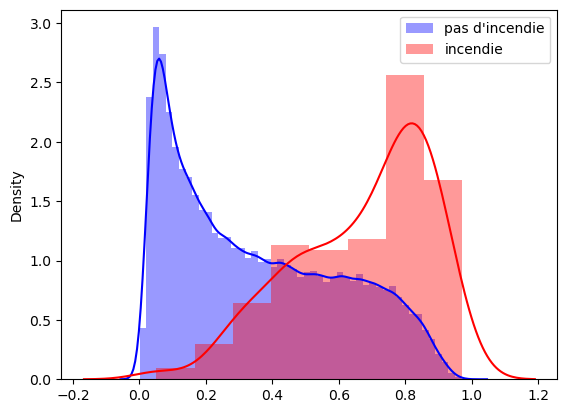

In [ ]:
plt.figure()
sns.distplot(proba0[:,1], color='blue', label="pas d'incendie")
sns.distplot(proba1[:,1], color='red', label="incendie")
plt.legend()
plt.show()

On remarque que même si beaucoup de données sont mal classifiées, le modèle donne bien des probabilités d'incendie plus élevées lorsqu'il y a eu un incendie.

Le modèle réussit alors à capter des influences des variables météorologiques sur le risque d'incendie

Etudions maintenant les coefficients de la régression logistique

In [ ]:
coeffs = pd.DataFrame(data= model.named_steps['classi'].coef_, columns = X.columns, index=['coefficient'])
coeffs

,dd,ff,t,td,precip,hu
coefficient,0.023002,0.250419,-1.105582,1.515885,0.081197,-1.753249


Les coefficients peuvent être comparés entre eux grâce à la standardisation des données. Plus la valeur absolue du coefficient est grande, plus la variable influe sur la probabilité d'être classifié en incendie. Un signe positif (resp. négatif) indique une relation croissante (resp. décroissante) entre la variable et le risque d'incendie.

Les variables les plus importantes semblent êtres l'humidité (hu) et les variables de température (t, td).

Notons un point surprenant : le coefficient associé à la température moyenne sur la journée (t) est négatif alors que cette variable est corrélée positivement à la variable incendie comme vu précédemment. Ceci est du au fait que la corrélation de t et td est de 0.9 donc il y a un effet de compensation entre le coefficient positif de td et le coefficient négatif de t. Pour avoir un modèle causal, il faudrait peut-être supprimer l'une des deux variables.

* Essai d'un autre modèle prédictif : AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = Pipeline([('scaler',StandardScaler()),
                      ('classi',AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=10,
    algorithm="SAMME.R",
    learning_rate=0.1,
    random_state=42
))]
                     )
ada.fit(X_train, y_train)

proba0_ada = ada.predict_proba(X_test[y_test==0])
proba1_ada = ada.predict_proba(X_test[y_test==1])

ypred_ada = ada.predict(X_test)

In [ ]:
print("matrice de confusion du nouveau modèle :")
print(confusion_matrix(y_test, ypred_ada))
print("matrice de confusion de la régression logistique :")
print(confusion_matrix(y_test, ypred))

matrice de confusion du nouveau modèle :
[[266856 136867]
 [    28    148]]
matrice de confusion de la régression logistique :
[[283299 120424]
 [    43    133]]


Ce nouveau modèle classe mieux les données avec incendie mais moins bien celles sans incendie.

In [ ]:
probabilities = model.predict_proba(X_test)
probabilities_ada = ada.predict_proba(X_test)

auc_roc = roc_auc_score(y_test, probabilities[:, 1])
auc_roc_ada =  roc_auc_score(y_test, probabilities_ada[:, 1])

print(f'AUC-ROC de la régression logistique: {auc_roc}')
print(f'AUC-ROC de AdaBoost: {auc_roc_ada}')

AUC-ROC de la régression logistique: 0.8285520726069383
AUC-ROC de AdaBoost: 0.8264087333844785


Les deux modèles obtiennent des scores auc-roc assez similaires, au sens de cette métrique ces deux modèles sont aussi bons classifiers.

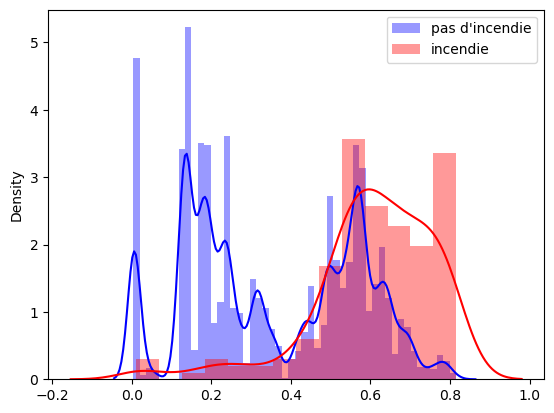

In [ ]:
plt.figure()
sns.distplot(proba0_ada[:,1], color='blue', label="pas d'incendie")
sns.distplot(proba1_ada[:,1], color='red', label="incendie")
plt.legend()
plt.show()

Les distributions de probabilités prédites sont différentes de celles de la régression logistique. On remarque qu'un pic de la distribution bleue correspond avec le pic de la distribution rouge. Cela correspond peut-être au fait que pour des mêmes conditions météo, il peut y avoir un incendie à un endroit et pas à un autre.

Le modèle AdaBoost basé sur des arbres de décisions a pour avantage de donner l'importance relatives des features dans la prédiction, ce qui est un équivalent des coefficients de la régression logistique, même si l'importance de la variable ne dit rien sur la nature de sa relation avec le risque d'incendie

In [ ]:
importances = pd.DataFrame(data= ada.named_steps['classi'].feature_importances_.reshape(1,6), columns = X.columns, index=['importance'])
importances

,dd,ff,t,td,precip,hu
importance,0.017271,0.074997,0.282401,0.005173,0.007443,0.612715


On remarque que deux variables météo se démarquent en terme d'importance : en premier lieu l'humidité (plus de 60%), puis la température moyenne sur la journée (t).

### Conclusion de la modélisation

Deux modèles de classification ont été essayé : la régression logistique et l'AdaBoost basé sur des arbres de décision. Les deux modèles ont des performances assez similaires. Bien que la qualité de prédiction ne soit pas excellente, on voit que ces modèles ont capté les influences des variables météo sur le risque d'incendie.

Les coefficients de la régression logistique et les feature importances de l'AdaBoost mènent vers la même conclusion. Deux variables météo ont une influence prédominante : en premier lieu l'humidité puis la température.

La relation entre le risque d'incendie et l'humidité est décroissante, ce qui correspond à l'idée qu'on s'en fait.

La relation entre la température semble croissante, mais la forte corrélation entre les deux variables de température (t et td) rend difficile l'interprétation des signes dess deux coefficients.

# Conclusion générale

Nous avons donc travaillé sur la prédiction du risque d'incendie à partir des variables météorologiques.

Ce sujet est particulièrement important compte tenu des augmentations des feux de forêt ces dernières années, et de l'augmentation qu'il pourrait y avoir en raison du changement climatique.

Afin de réaliser notre projet, nous avons utilisé trois bases de données :
- une base de données répertoriant les feux de forêt en France métropolitaine pour l'année 2018 (BDIFF).
- une base de données météo France donnant l'état des variables météorologiques toutes les 6 minutes dans chacune des stations météo du sud-est de la France.
- une base de données INSEE donnant les localisations (latitude/longitude) des différentes communes, afin d'associer les communes où il y a eu des incendies à la stations météo la plus proche.

Nous avons commencé par réaliser cette association entre les communes et les stations météo. Puis, nous avons pouvons créer une base de données contenant les données météo moyennes (sur une journée) pour chaque commune et chaque jour de l'année, avec le fait qu'il y ait eu ou non un incendie ce jour là.

Cette base de données ainsi crée, nous avons étudié des statistiques descriptives sur les feux de forêt et sur les variables météorologiques.

Ensuite, nous avons étudié les influences des variables météorologiques sur l'occurence d'un incendie par l'étude des distributions conditionnelles. Nous avons vérifié ces influences par des tests statistiques étudiant des différences moyennes et médianes des variables météo lorsqu'il y eu un incendie par rapport à lorsqu'il n'y en a pas eu. Le test de corrélation a fourni une nouvelle approche pour vérifier si ces variables étaient ou non corrélées à l'occurence de l'incendie.

Ces tests statistiques réalisés, nous avons identifiés les variables qui semblaient associées au risque d'incendie. Ces variables ont donc été sélectionnées comme features pour la modélisation des modèles de prédiction d'incendie.

Nous avons alors réalisé deux modèles de prédiction d'incendie :
- la régression logistique
- un modèle AdaBoost basé sur des arbres de décision.

Ces deux modèles ont plus ou moins le même pouvoir prédictif. Ils réussissent à capter des influences significatives des variables météo sur le risque d'incendie.

Les coefficients de la régression logistique et les importances relatives de chaque feature pour la prédiction données par AdaBoost ont mené vers les mêmes conclusions.

Parmi les variables étudiées, celle qui a l'impact le plus significatif est l'humidité qui est en relation décroissante avec le risque d'incendie. La deuxième variable la plus importante est la température qui est en relation croissante avec le risque d'incendie. L'importance des autres variables météorologiques est beaucoup plus faible.

Les données climatiques influencent alors signicativement le risque d'incendie, particulièrement l'humidité et la température. Ceci corrobore l'idée que le réchauffement climatique pourrait augmenter le nombre d'occurences des feux de forêt dans les années à venir.

Notre étude aurait pu être améliorée notamment avec une base de données météo plus riche incluant d'autres variables.

De plus, elle pourrait être élargie en étudiant l'impact de la fréquentation des forêts, compte tenu du fait que de nombreux incendies sont d'origine humaine. La présence de lignes haute tension dans les forêts pourrait également être étudiée.

Les données météo ont des distributions souvent continues (sauf precip) mais sans normalité. 

Il est à noter certaines corrélations entre elles, notamment entre t et td. Ceci devra être pris en compte lors de l'interprétation des coefficients de la régression logistique.